# Carga del *User Knowledge Modeling Data Set*.

Comenzamos realizando la carga del *User Knowledge Modeling Data Set* mediante ``pandas`` y su función ``read_csv()``. 

In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv('./user_knowledge_train.csv', header = 0)
print(df.shape)
df.head()

(258, 6)


,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,very_low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low


Como puede observarse de la salida anterior, tenemos un *DataFrame* con 258 instancias y 6 características por instancia. Las 5 primeras instancias son de tipo numérico en el intervalo [0, 1] por lo que no es necesario realizar un proceso de normalizado.

In [14]:
df['UNS'].value_counts()

Middle      88
Low         83
High        63
very_low    24
Name: UNS, dtype: int64

Al realizar un conteo obtenemos 4 clases diferentes con números diferentes de instancias por clase. A continuación, realizamos el separado de variables de entrada y variable objetivo, pues los algoritmos de clustering se sirven únicamente de las variables de entrada.

In [15]:
X = df[df.columns[:-1]]
Y = df[df.columns[-1]]

X.head()

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


Realizamos un primer proceso de separación en *clústers* en el que consideramos tantos grupos (``n_clusters``) como clases hay en el Data Set. Haremos uso de una técnica particional con ``KMeans`` y de una técnica jerárquica aglomerativa con ``AgglomerativeClustering``. 

In [16]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

n_classes = 4

kmeans = KMeans(n_clusters = n_classes)
ag_cl = AgglomerativeClustering(n_clusters = n_classes, linkage = 'complete')

kmeans.fit(X)
ag_cl.fit(X)

AgglomerativeClustering(linkage='complete', n_clusters=4)

In [17]:
np.unique(kmeans.labels_, return_counts = True)

(array([0, 1, 2, 3]), array([ 66, 105,  58,  29], dtype=int64))

In [18]:
np.unique(ag_cl.labels_, return_counts = True)

(array([0, 1, 2, 3], dtype=int64), array([125,  86,  19,  28], dtype=int64))

Realizando un conteo de elementos por etiqueta en cada algoritmo de clústering podemos ver algunas similitudes con las clases originales. Por una parte, parecen existir dos clases con el mayor número de instancias (``Middle`` y ``Low`` en el data set original), una tercera con un número un tanto inferior (``High`` en el data set original), y una cuarta que tiene un número considerablemente inferior al resto (``very_low`` en el data set original). Sin embargo, se observan bastantes diferencias respecto al número absoluto de instancias por cada clase, lo que nos lleva a pensar que los algoritmos de clústering generan grupos diferentes a las clases del data set original. 

Por otra parte, si realizamos un clustering jerárquico aglomerativo y lo dibujamos mediante la función ``dendogram`` y ``linkage`` se obtiene el *dendograma* que se muestra más abajo. Este dendograma parece sugerir que este algoritmo realiza un agrupado en 4 clústers que pueden diferenciarse por los colores rojo, naranja, verde y morado.

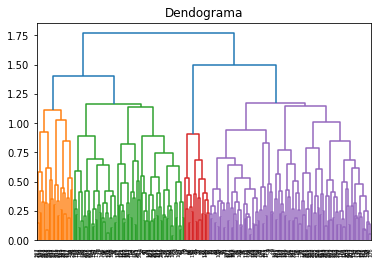

In [19]:
import scipy.cluster.hierarchy as dnd
plt.figure()
plt.title('Dendograma')
dend = dnd.dendrogram(dnd.linkage(X, method = 'complete'))
plt.show()

Visto todo esto, cabe formularse la pregunta de si el número de clústers escogido es el adecuado para este problema concreto. Para ello, haremos uso de dos estrategias. 

- Haremos uso del método del codo y graficaremos la ``inertia`` frente al número de k's. La ``inertia`` se puede entender como la suma al cuadrado de las distancias de cada punto al centroide del clúster más cercano.

- Haciendo uso del ``silhouete_score`` y dibujándolo frente al número de k's. El coeficiente de silueta se calcula utilizando la distancia media intra-cluster (``a``) y la distancia media entre clusters más cercanos (``b``) de cada muestra. El coeficiente de silueta de una muestra es ``(b - a) / max(a, b)``. La distancia ``b`` es la distancia de cada muestra con el clúster más cercano del que NO forma parte. En ``sklearn``, ``silhouete_score`` obtiene una media del valor para todas las muestras. 

Muchas veces el método del codo presenta la desventaja de que no es evidente a nivel visual identificar el "codo" de la gráfica y podemos encontrarnos con la indecisión de que k seleccionar. Por ello, en muchas ocasiones resulta especialmente útil ``silhouete_score`` pues suele exhibir un "pico" o máximo al ser dibujado frente a k, lo que facilita el identificado del número idóneo de clústers.

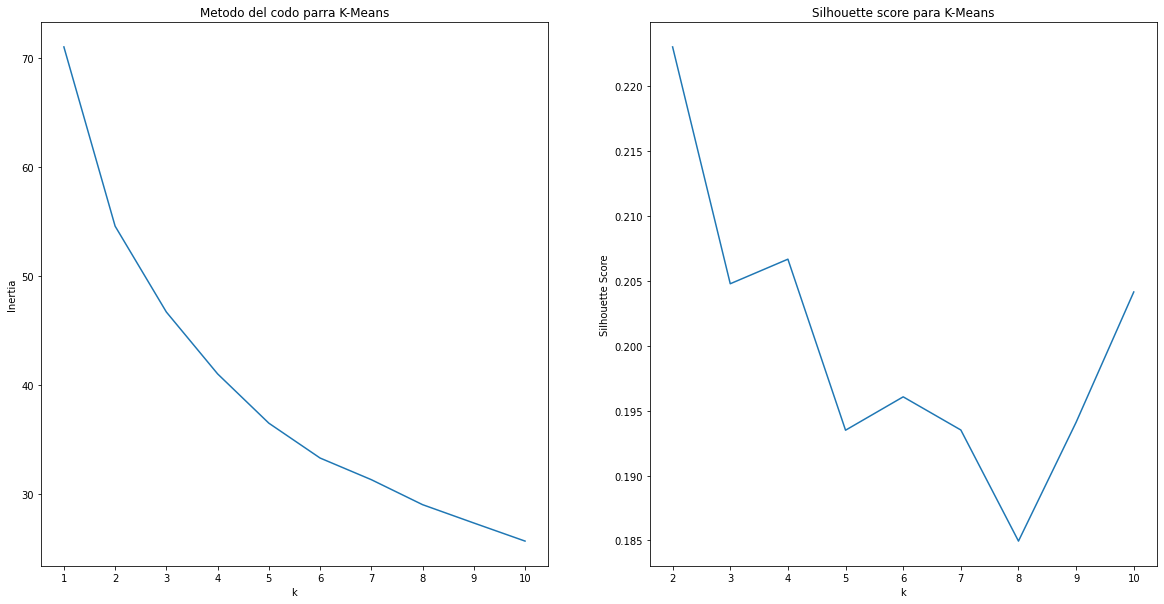

In [20]:
km_in, km_sil = [], []
for k in range(1, 11):
    k_temp = KMeans(n_clusters = k)
    k_temp.fit(X)
    km_in.append(k_temp.inertia_)
    if k > 1:
        km_sil.append(silhouette_score(X, k_temp.labels_))

fig, ax = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(20, 10)
#fig.suptitle('Método del codo para K-Means')
ax[0].set_title('Metodo del codo parra K-Means')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia')
ax[0].set_xticks(range(1, 11))
ax[0].plot(range(1, 11), km_in)
ax[1].set_title('Silhouette score para K-Means')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_xticks(range(2, 11))
ax[1].plot(range(2, 11), km_sil)
plt.show()

En este caso, podemos ver en la gráfica de la izquierda un "codo" para ``k = 2``, pues a partir de este punto la ``inertia`` deja de caer de forma tan abrupta. Por otra parte, la gráfica de la derecha también muestra un pico del ``silhouette_score`` para ``k = 2`` lo que parece corroborar este número como el número idóneo de clústers. En cualquier caso, se podría discutir si otros puntos como ``k = 3`` también presentan cierto cambio brusco en la tendencia de la línea.

Como puede observarse también, tanto ``k = 2`` o ``k = 3`` no coinciden con lo 4 clústers que habíamos fijado más arriba, es decir, este algoritmo agruparía las instancias en menos grupos que clases existen en el data set original.

También podemos preguntarnos si nuestra separación en clústers con ``k = 4`` coincide con las clases originales del data set. Para ello, vamos a realizar una reducción de dimensionalidad PCA con ``n_components = 3`` (es decir nos quedaremos con 3 dimensiones ortogonales que, en este caso, explican aproximadamente un 75% de la varianza). Seguidamente, realizaremos una representación en 2D de las dos primeras componentes principales, mostrando con diferentes colores cada grupo o clase. 

[0.30196292 0.24277184 0.19440398]


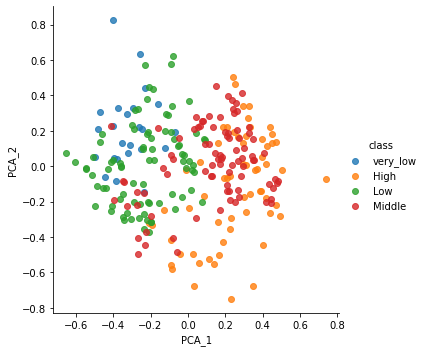

In [21]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
aux_df = pd.DataFrame(X_pca, columns = ['PCA_1', 'PCA_2', 'PCA_3'])
aux_df['class'] = Y

sns.lmplot(x = 'PCA_1', y = 'PCA_2', data = aux_df, hue = 'class', fit_reg = False)
plt.show()

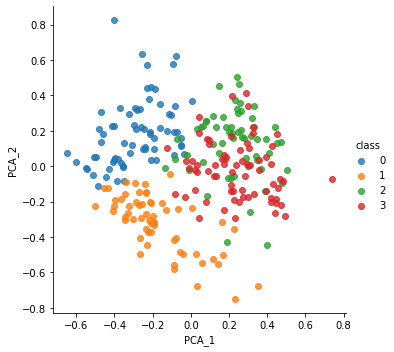

In [22]:
aux_df_2 = pd.DataFrame(X_pca, columns = ['PCA_1', 'PCA_2', 'PCA_3'])
kmeans_pca = KMeans(n_clusters = n_classes)
kmeans_pca.fit(X_pca)
aux_df_2['class'] = kmeans_pca.labels_

sns.lmplot(x = 'PCA_1', y = 'PCA_2', data = aux_df_2, hue = 'class', fit_reg = False)
plt.show()

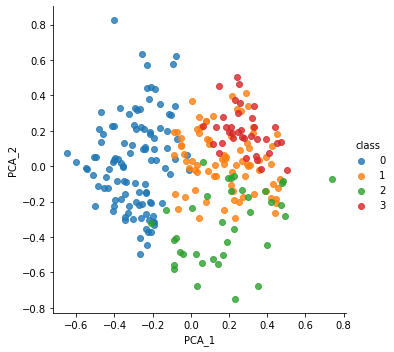

In [23]:
aux_df_3 = pd.DataFrame(X_pca, columns = ['PCA_1', 'PCA_2', 'PCA_3'])
agcl_pca = AgglomerativeClustering(n_clusters = n_classes, linkage = 'ward')
agcl_pca.fit(X_pca)
aux_df_3['class'] = agcl_pca.labels_

sns.lmplot(x = 'PCA_1', y = 'PCA_2', data = aux_df_3, hue = 'class', fit_reg = False)
plt.show()

In [24]:
np.unique(kmeans_pca.labels_, return_counts = True)

(array([0, 1, 2, 3]), array([69, 59, 58, 72], dtype=int64))

De las gráficas anteriores podemos observar como los algoritmos de clustering generan grupos similares a las clases del data set original, pero no se ajustan de forma idónea a los mismos. En definitiva, si utilizásemos algoritmos de clústering para extraer conclusiones sobre las diferentes posibles agrupaciones sobre este conjunto de datos, obtendríamos resultados diferentes a la partición en clases que sugiere el data set original.